---
# Practical work on deformable models
## Author: Mohammed Aroui
---

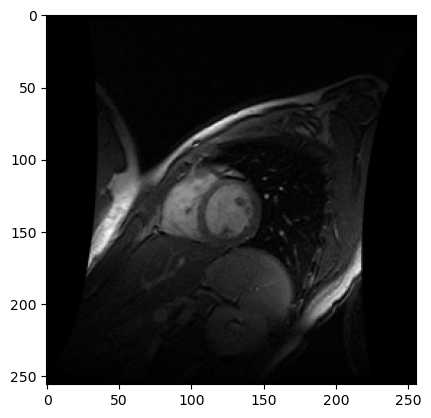

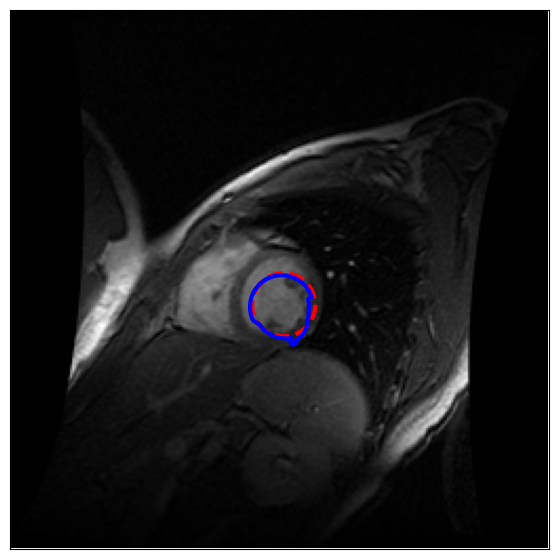

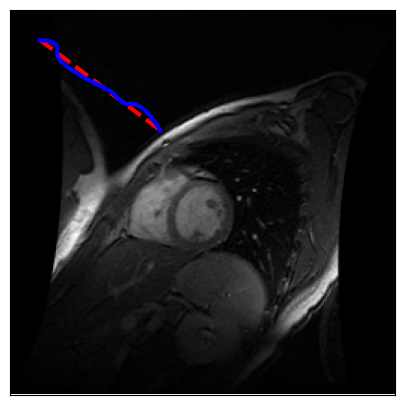

/tmp/ipykernel_380026/481940347.py:96: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  cv = chan_vese(image, mu=0.25, lambda1=5, lambda2=1, tol=1e-3, max_iter=200,


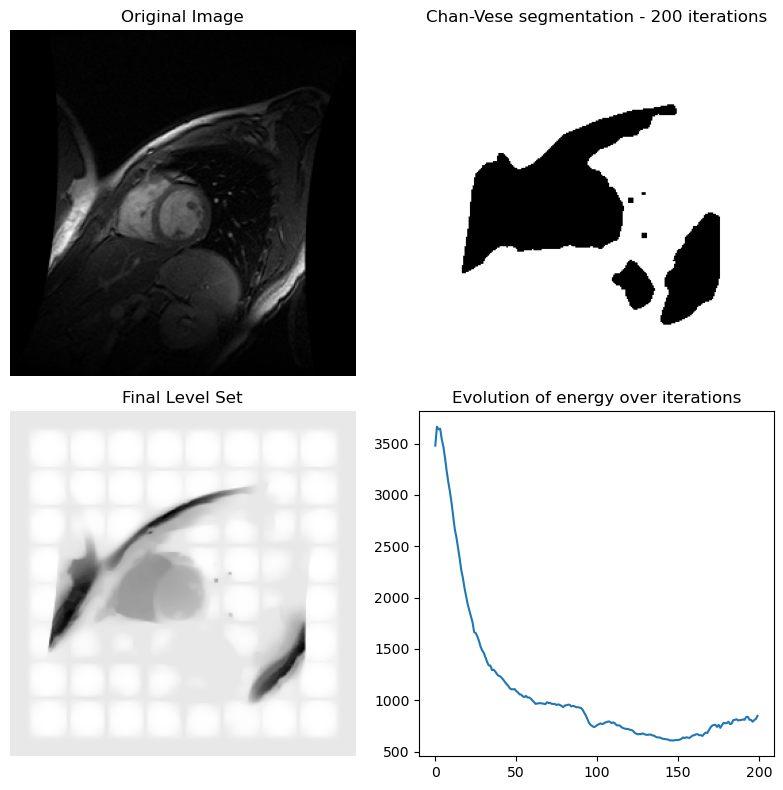

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" I. Bloch
"""


#%% SECTION 1 inclusion of packages 


import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import checkerboard_level_set
from skimage.segmentation import disk_level_set

#%% SECTION 2 - Input image

im=skio.imread('coeurIRM.bmp')

#im=skio.imread('retineOA.bmp')

#im=skio.imread('brain.bmp')
#im=im[:,:,1]

#im=skio.imread('brain2.bmp')

plt.imshow(im, cmap="gray", vmin=0, vmax=255)

#%% SECTION 3a - Segmentation using active contours 

s = np.linspace(0, 2*np.pi, 100)
r = 140 + 15*np.sin(s)
c = 130 + 15*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(im, 0.1),
                       init, alpha=0.5, beta=5, w_edge=20, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, im.shape[1], im.shape[0], 0])

plt.show()

#%% SECTION 3b - Open contours

# Use retineOA.bmp

r = np.linspace(20, 80, 100)
c = np.linspace(20, 100, 100)
init = np.array([r, c]).T

snake = active_contour(gaussian(im, 1), init, boundary_condition='fixed',
                       alpha=0.01, beta=2, w_line=0, w_edge=10, gamma=0.01)

fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, im.shape[1], im.shape[0], 0])

plt.show()

#%% SECTION 4 - Segmentation using level sets (and region homogeneity)

image = img_as_float(im)

# Init avec un damier
#init_ls = checkerboard_level_set(image.shape, 6)

# Init avec un cercle
#init_ls = circle_level_set (image.shape, (120,130), 10)

# Init avec plusieurs cercles
circleNum = 8
circleRadius = image.shape[0] / (3*circleNum)
circleStep0 = image.shape[0]/(circleNum+1)
circleStep1 = image.shape[1]/(circleNum+1)
init_ls = np.zeros(image.shape)
for i in range(circleNum):
        for j in range(circleNum):
            init_ls = init_ls + disk_level_set (image.shape, 
                                                  center=((i+1)*circleStep0, (j+1)*circleStep1), radius=circleRadius)


cv = chan_vese(image, mu=0.25, lambda1=5, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set=init_ls, extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

     
#%% END  TP - Deformable Models


In [4]:
def niceDisplay14_bis(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >5 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
    plt.gray()
    fig , ax = plt.subplots(1,nb_affichages)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    for i in range(0,nb_affichages):
        ax[i].imshow(affichages[i])
        ax[i].set_title(titres[i])

    plt.show()

---
# 1) Parameters
---

### First method: skimage.segmentation.active_contour

This method represents the contour explicitly as a parametric curve. The evolution of the contour is formulated as curve deformation minimizing an energy function.
Here’s a detailed explanation of each parameter and its role:

- **image**: This is the input image that we want to segment. It can be a 2D (grayscale) or 3D (color) image. In our case, we use gaussian to smooth the input image. 

- **snake**: These are the initial coordinates of the active contour. The active contour model will start from these coordinates and evolve to fit the features of the image.

- **boundary_condition**: This parameter determines whether the active contour (snake) is periodic (forming a closed loop) or has fixed/free ends. In our case, ‘fixed’ means that the ends of the snake are fixed and do not move.

- **alpha**: This is a shape parameter that controls the snake’s length. Higher values make the snake contract faster. It’s used to minimize partitioning of the snake into separate parts.

- **beta**: This is another shape parameter that controls the smoothness of the snake. Higher values make the snake smoother, reducing its flexibility.

- **w_line**: This parameter controls the attraction of the snake to brightness in the image. If we use negative values, it will attract towards dark regions. In our case, setting it to 0 means there’s no attraction to brightness.

- **w_edge**: This parameter controls the attraction of the snake to edges in the image. Negative values repel the snake from edges. In our case, setting it to 10 means there’s a strong attraction to edges.

- **gamma**: This is a parameter for an explicit time stepping scheme.

**alpha**

Increasing alpha will make your snake contract more quickly, which might make it more sensitive to smaller objects but also more prone to shrinking too much.

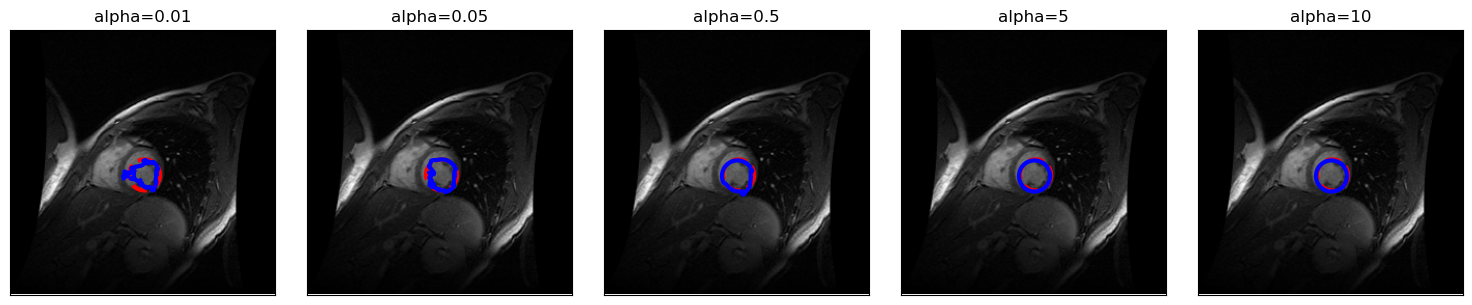

In [10]:
alphas=[1,5,10,15,20]
im=skio.imread('coeurIRM.bmp')
s = np.linspace(0, 2*np.pi, 100)
r = 140 + 15*np.sin(s)
c = 130 + 15*np.cos(s)
init = np.array([r, c]).T

# Assuming 'im' is your image and 'init' is your initial snake coordinates
alphas = [0.01,0.05, 0.5, 5, 10]  # Modify this list as per your alpha values

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, alpha in enumerate(alphas):
    snake = active_contour(gaussian(im, 0.1),
                       init, alpha=alpha, beta=5, w_edge=20, gamma=0.001)
    axs[i].imshow(im, cmap=plt.cm.gray)
    axs[i].plot(init[:, 1], init[:, 0], '--r', lw=3)
    axs[i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    axs[i].set_xticks([]), axs[i].set_yticks([])
    axs[i].axis([0, im.shape[1], im.shape[0], 0])
    axs[i].set_title(f'alpha={alpha}')

plt.tight_layout()
plt.show()

**beta**

Increasing beta will make your snake smoother but less flexible, which might make it less sensitive to small objects or irregular shapes.

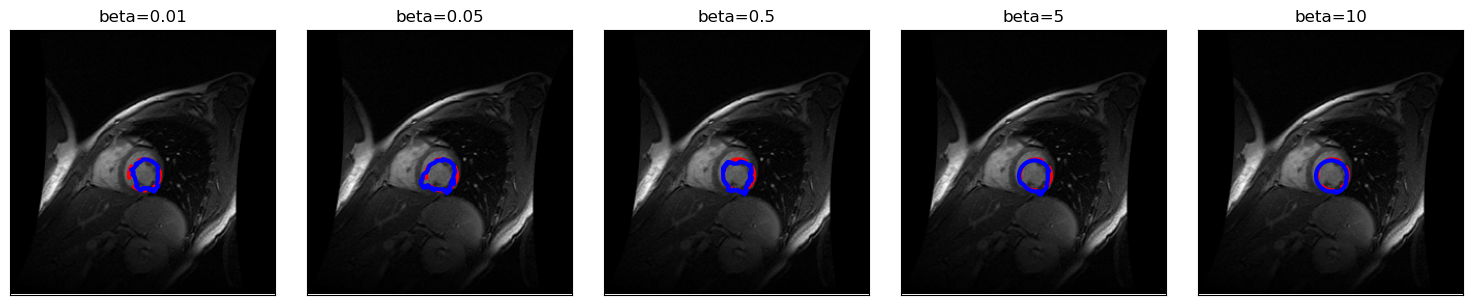

In [13]:
alphas=[1,5,10,15,20]
im=skio.imread('coeurIRM.bmp')
s = np.linspace(0, 2*np.pi, 100)
r = 140 + 15*np.sin(s)
c = 130 + 15*np.cos(s)
init = np.array([r, c]).T

# 'init' is your initial snake coordinates
betas = [0.01,0.05, 0.5, 5, 10]  # Modify this list as per your alpha values

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, beta in enumerate(betas):
    snake = active_contour(gaussian(im, 0.1),
                       init, alpha=0.5, beta=beta, w_edge=20, gamma=0.001)
    axs[i].imshow(im, cmap=plt.cm.gray)
    axs[i].plot(init[:, 1], init[:, 0], '--r', lw=3)
    axs[i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    axs[i].set_xticks([]), axs[i].set_yticks([])
    axs[i].axis([0, im.shape[1], im.shape[0], 0])
    axs[i].set_title(f'beta={beta}')

plt.tight_layout()
plt.show()

**w_line**

This parameter controls the attraction of the snake to brightness in the image. If we use negative values, it will attract towards dark regions

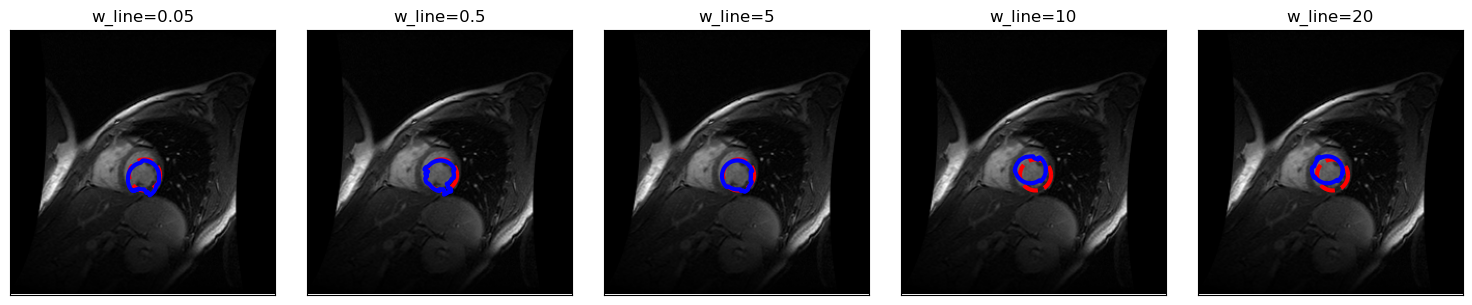

In [9]:
im=skio.imread('coeurIRM.bmp')
s = np.linspace(0, 2*np.pi, 100)
r = 140 + 15*np.sin(s)
c = 130 + 15*np.cos(s)
init = np.array([r, c]).T

# 'init' is your initial snake coordinates
lines = [0.05, 0.5,5, 10, 20]  # Modify this list as per your alpha values

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, line in enumerate(lines):
    snake = active_contour(gaussian(im, 0.1),
                       init, alpha=0.5, beta=2,w_line=line, w_edge=20, gamma=0.001)
    axs[i].imshow(im, cmap=plt.cm.gray)
    axs[i].plot(init[:, 1], init[:, 0], '--r', lw=3)
    axs[i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    axs[i].set_xticks([]), axs[i].set_yticks([])
    axs[i].axis([0, im.shape[1], im.shape[0], 0])
    axs[i].set_title(f'w_line={line}')

plt.tight_layout()
plt.show()

**w_edge**

This parameter controls the attraction of the snake to edges in the image. Negative values repel the snake from edges.

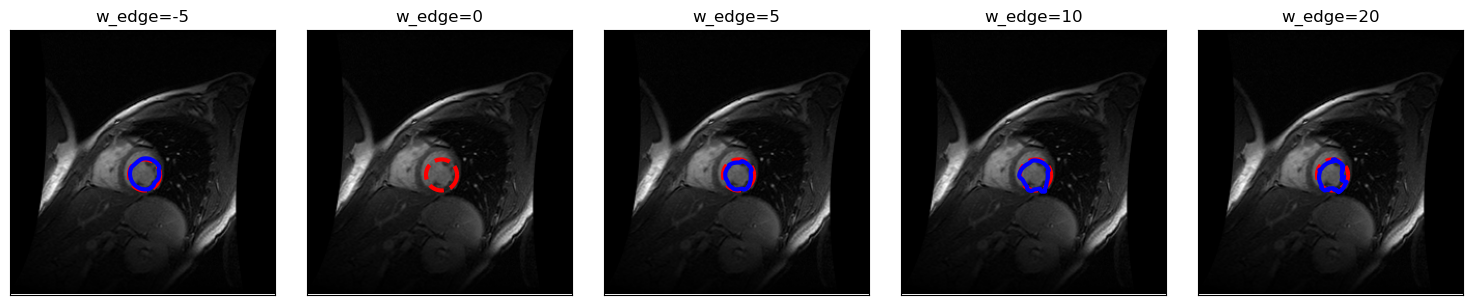

In [8]:
im=skio.imread('coeurIRM.bmp')
s = np.linspace(0, 2*np.pi, 100)
r = 140 + 15*np.sin(s)
c = 130 + 15*np.cos(s)
init = np.array([r, c]).T

# 'init' is the initial snake coordinates

lines = [-5,0,5, 10, 20]  

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, line in enumerate(lines):
    snake = active_contour(gaussian(im, 0.1),
                       init, alpha=0.5, beta=2,w_line=0, w_edge=line, gamma=0.001)
    axs[i].imshow(im, cmap=plt.cm.gray)
    axs[i].plot(init[:, 1], init[:, 0], '--r', lw=3)
    axs[i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    axs[i].set_xticks([]), axs[i].set_yticks([])
    axs[i].axis([0, im.shape[1], im.shape[0], 0])
    axs[i].set_title(f'w_edge={line}')

plt.tight_layout()
plt.show()

### second method: skimage.segmentation.chan_vese

The method is a segmentation algorithm designed to segment objects without clearly defined boundaries. Here’s a detailed explanation of each parameter and its role:

- **image**: This is the input image that you want to segment. It should be a grayscale image.

- **mu**: This parameter is typically between 0 and 1. It controls the level set’s attraction to the image edges.Higher values, removes a lot of details in the segmentation.

- **lambda1** and **lambda2**: These parameters control the attraction of the level set function to the image intensities inside and outside the segmented region, respectively.

- **tol**: This is the tolerance parameter. If the L2 norm difference between the level sets of successive iterations normalized by the area of the image is below this value, the algorithm will assume that the solution was reached.

- **max_num_iter**: This is the maximum number of iterations allowed before the algorithm interrupts itself.

- **dt**: This is a multiplication factor applied at calculations for each step, which serves to accelerate the algorithm.

- **init_level_set**: This parameter determines how to initialize the level set function.

- **extended_output**: If this is set to True, the function will return a list of values that corresponds to the energy at each iteration.


In [16]:
def vis_chan_vese(image,mu,lambda1,lambda2,tol,max_iter,dt,init_level_set,extended_output): 
    cv = chan_vese(image, mu=mu, lambda1=lambda1, lambda2=lambda2, tol=tol, max_iter=max_iter,
                dt=dt, init_level_set=init_level_set, extended_output=extended_output)


    fig, axes = plt.subplots(1, 4, figsize=(15, 3))
    ax = axes.flatten()

    ax[0].imshow(image, cmap="gray")
    ax[0].set_axis_off()
    ax[0].set_title("Original Image", fontsize=12)

    ax[1].imshow(cv[0], cmap="gray")
    ax[1].set_axis_off()
    title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
    ax[1].set_title(title, fontsize=12)

    ax[2].imshow(cv[1], cmap="gray")
    ax[2].set_axis_off()
    ax[2].set_title("Final Level Set", fontsize=12)

    ax[3].plot(cv[2])
    ax[3].set_title("Evolution of energy over iterations", fontsize=12)

    fig.tight_layout()
    plt.show()


**mu**
This parameter is typically between 0 and 1. It controls the level set’s attraction to the image edges.
Higher values, removes a lot of details in the segmentation.

/tmp/ipykernel_380026/3813802457.py:2: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  cv = chan_vese(image, mu=mu, lambda1=lambda1, lambda2=lambda2, tol=tol, max_iter=max_iter,


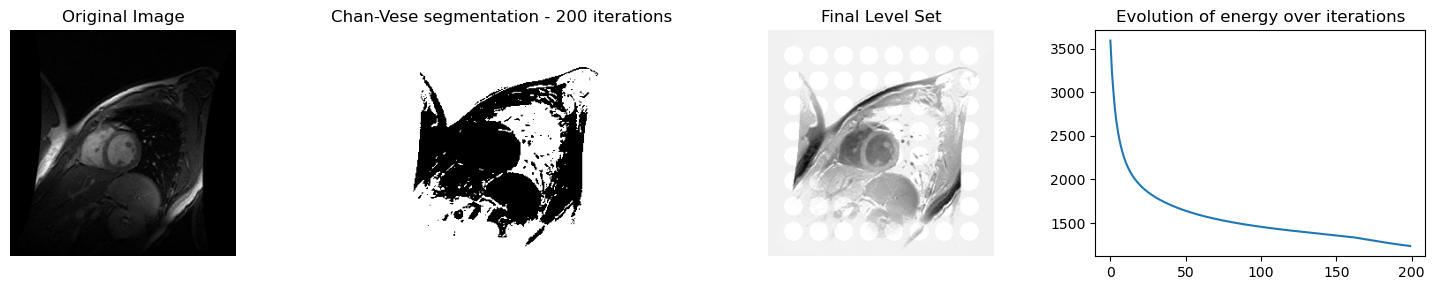

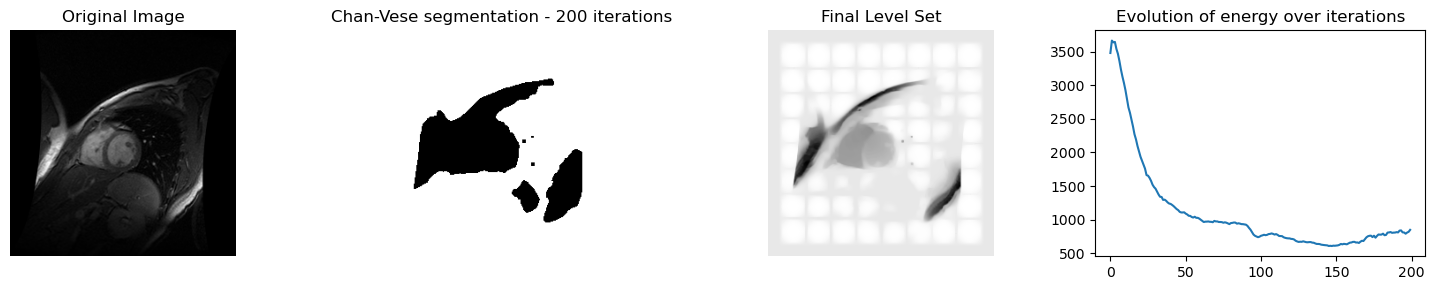

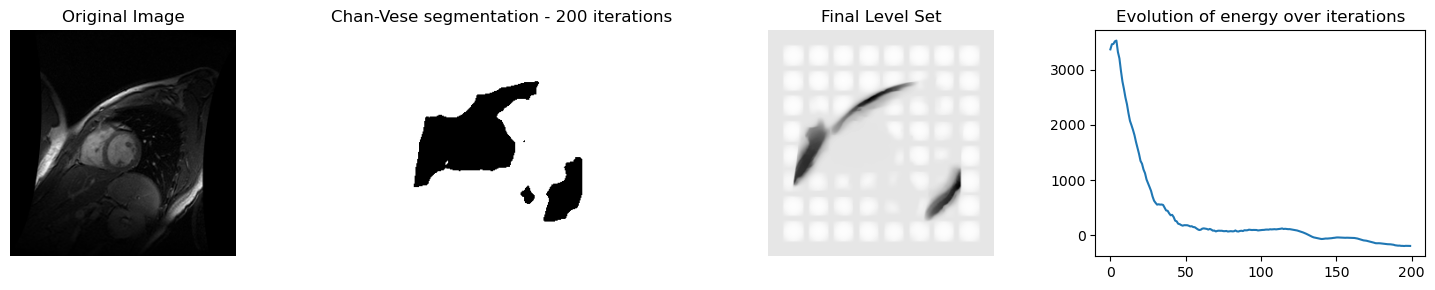

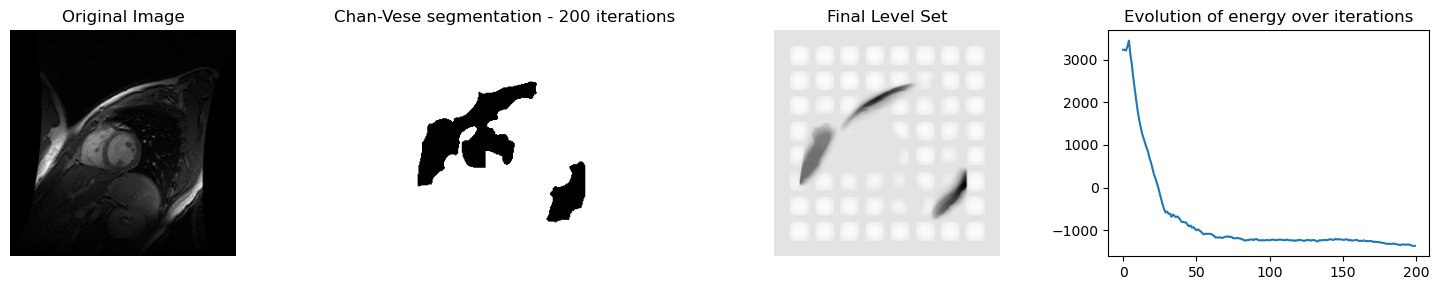

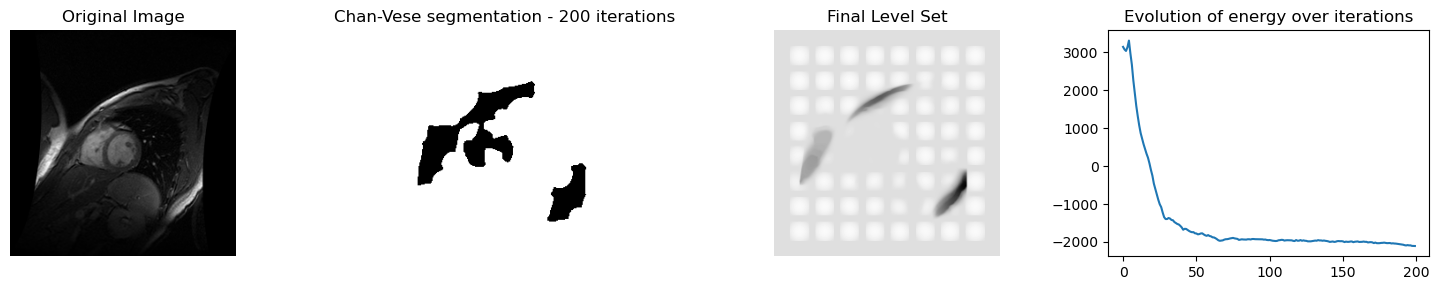

In [17]:
image = img_as_float(im)

# Init avec plusieurs cercles
circleNum = 8
circleRadius = image.shape[0] / (3*circleNum)
circleStep0 = image.shape[0]/(circleNum+1)
circleStep1 = image.shape[1]/(circleNum+1)
init_ls = np.zeros(image.shape)
for i in range(circleNum):
        for j in range(circleNum):
            init_ls = init_ls + disk_level_set (image.shape, 
                                                  center=((i+1)*circleStep0, (j+1)*circleStep1), radius=circleRadius)

for mu in [0,0.25,0.5,0.8,1]:
    vis_chan_vese(image, mu=mu, lambda1=5, lambda2=1, tol=1e-3, max_iter=200,
                dt=0.5, init_level_set=init_ls, extended_output=True)


**lambda1** and **lambda2**
as seen in the course:
Contour $\Gamma$

R1=int($\Gamma$) and R2=ext($\Gamma$).

When $\lambda_1 \gt \lambda_2$: The level set function is attracted to the image intensities in R1 

When $\lambda_2 \gt \lambda_1$: The level set function is attracted to the image intensities in R2 

/tmp/ipykernel_380026/3813802457.py:2: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  cv = chan_vese(image, mu=mu, lambda1=lambda1, lambda2=lambda2, tol=tol, max_iter=max_iter,


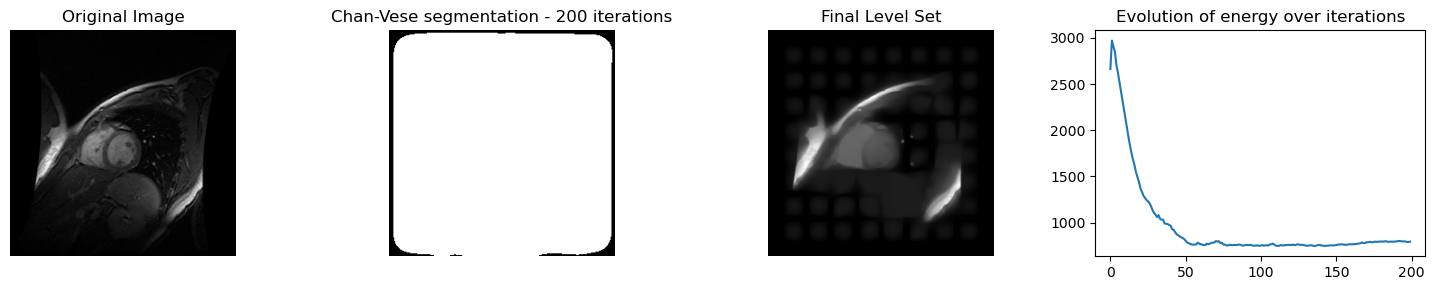

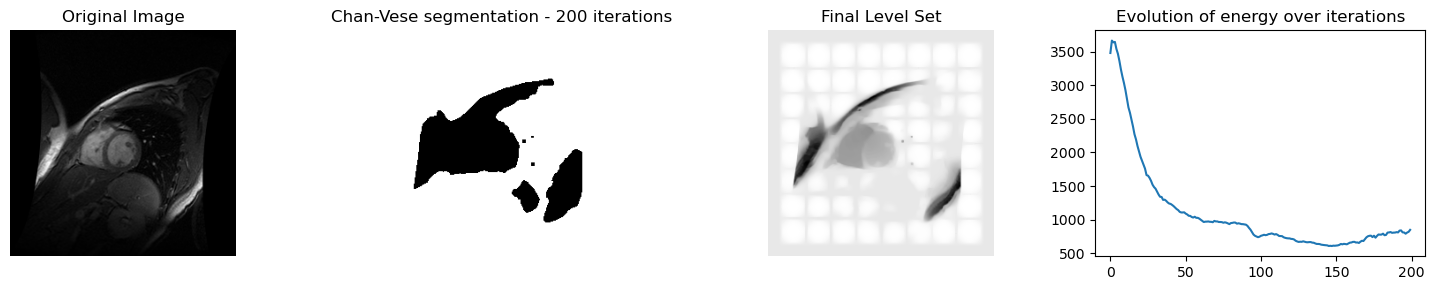

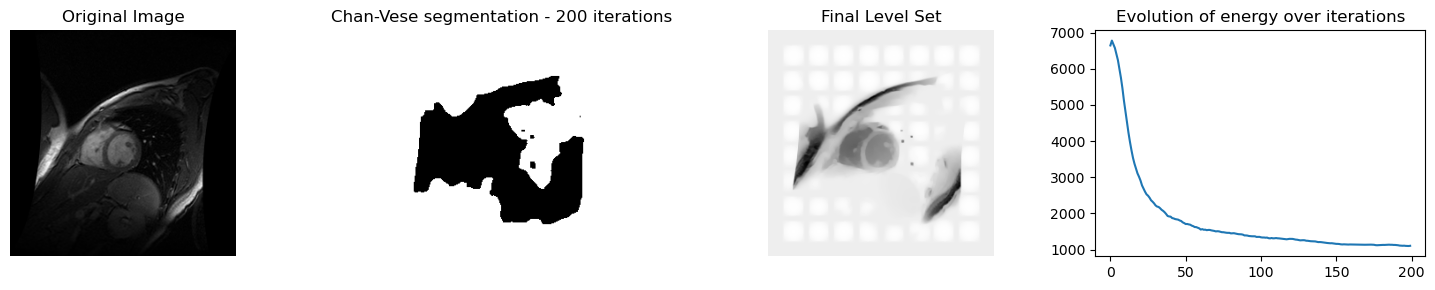

In [23]:
image = img_as_float(im)

# Init avec plusieurs cercles
circleNum = 8
circleRadius = image.shape[0] / (3*circleNum)
circleStep0 = image.shape[0]/(circleNum+1)
circleStep1 = image.shape[1]/(circleNum+1)
init_ls = np.zeros(image.shape)
for i in range(circleNum):
        for j in range(circleNum):
            init_ls = init_ls + disk_level_set (image.shape, 
                                                  center=((i+1)*circleStep0, (j+1)*circleStep1), radius=circleRadius)

for lambda1,lambda2 in [(1,5),(5,1),(10,1)]:
      vis_chan_vese(image, mu=0.25, lambda1=lambda1, lambda2=lambda2, tol=1e-3, max_iter=200,
                dt=0.5, init_level_set=init_ls, extended_output=True)

**init_level_set**

Initialization is very important. As shown below, initializing with a single disk, gives a bad segmentation.


/tmp/ipykernel_380026/3813802457.py:2: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  cv = chan_vese(image, mu=mu, lambda1=lambda1, lambda2=lambda2, tol=tol, max_iter=max_iter,


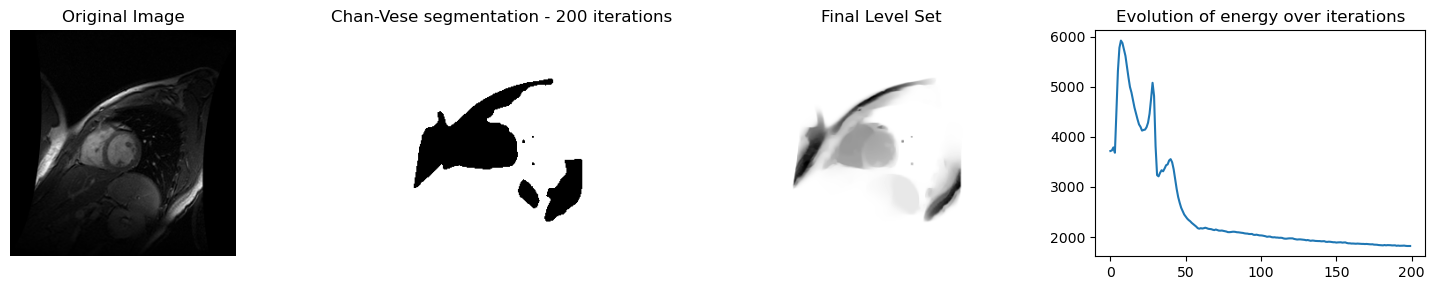

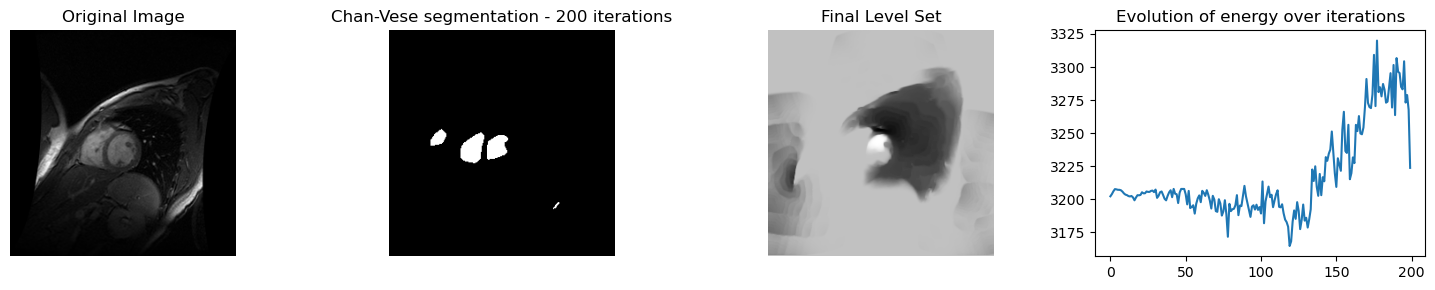

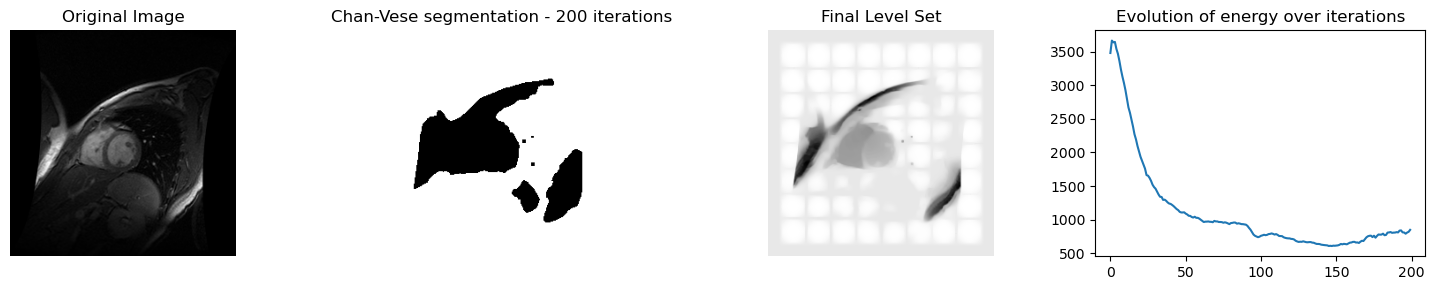

In [30]:
image = img_as_float(im)
# Init avec un damier
init_ls_check = checkerboard_level_set(image.shape, 6)

# Init avec un cercle
init_ls_one_disk = disk_level_set(image.shape, center=(120,130), radius=10)

# Init avec plusieurs cercles
circleNum = 8
circleRadius = image.shape[0] / (3*circleNum)
circleStep0 = image.shape[0]/(circleNum+1)
circleStep1 = image.shape[1]/(circleNum+1)
init_ls_m_disk = np.zeros(image.shape)
for i in range(circleNum):
        for j in range(circleNum):
            init_ls_m_disk = init_ls_m_disk + disk_level_set (image.shape, 
                                                  center=((i+1)*circleStep0, (j+1)*circleStep1), radius=circleRadius)

for init_ls in [init_ls_check,init_ls_one_disk,init_ls_m_disk]:
      vis_chan_vese(image, mu=0.25, lambda1=5, lambda2=1, tol=1e-3, max_iter=200,
                dt=0.5, init_level_set=init_ls, extended_output=True)

---
# 2) Segmentation
---

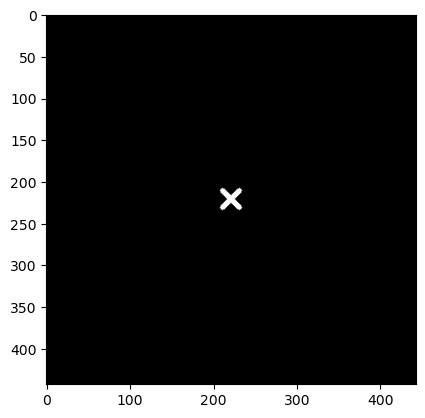

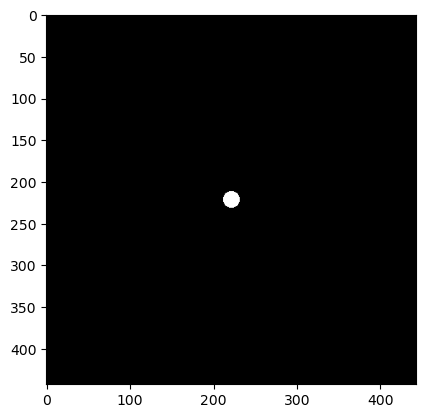

/tmp/ipykernel_380026/3813802457.py:2: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  cv = chan_vese(image, mu=mu, lambda1=lambda1, lambda2=lambda2, tol=tol, max_iter=max_iter,


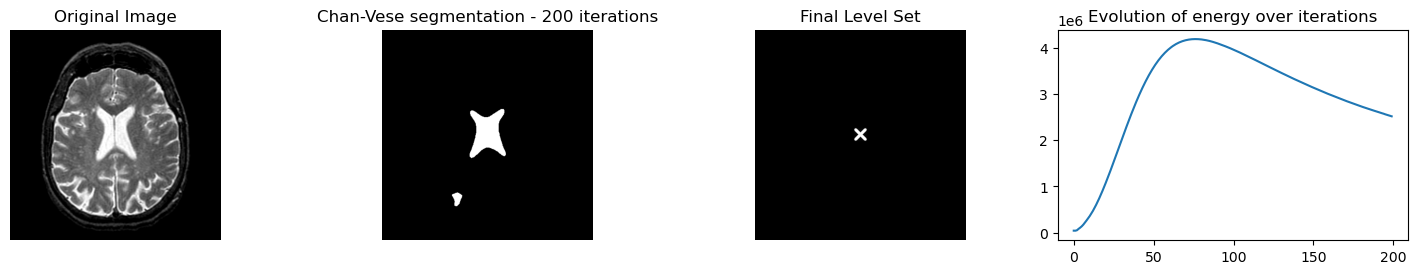

In [65]:
import cv2
image=skio.imread('brain.bmp')
image=image[:,:,1]
mask = np.zeros_like(image)

# Get the center point of the image
h, w = image.shape[:2]
center = (w // 2, h // 2)

cw=w//2
ch=h//2

# Draw a cross in the middle of the mask
cv2.line(mask, (cw-10, ch-10), (cw+10, ch+10), (255, 255, 255), thickness=5)
cv2.line(mask, (cw-10, ch+10), (cw+10, ch-10), (255, 255, 255), thickness=5)
plt.imshow(mask,cmap='gray')
plt.show()
"""import skimage.morphology as morpho 

se4 = morpho.disk(4)
open4 = morpho.opening(image,se4)
image=morpho.reconstruction(open4,image)"""



# Init avec un cercle
init_ls_one_disk = disk_level_set(image.shape, center=(image.shape[0]/2,image.shape[1]/2), radius=10)
plt.imshow(init_ls_one_disk,cmap='gray')
plt.show()
vis_chan_vese(image, mu=5, lambda1=5, lambda2=1, tol=1e-3, max_iter=200,
                dt=0.5, init_level_set=mask, extended_output=True)